# Медианные фильтры

## Подготовка

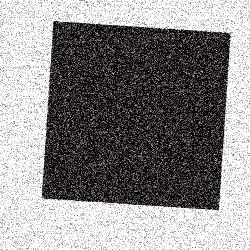

In [6]:
import numpy as np
from PIL import Image

# Загрузим тестовое изображение и представим его в виде np.array
image = Image.open("samples/Original.bmp")
image = np.array(image)

# Для ускорения проверки обрежем исходное изображение
SMALLER_SIZE = 250
image = image[:SMALLER_SIZE, :SMALLER_SIZE, :]

# Посмотрим на исходное изображение
Image.fromarray(image)

In [7]:
# Будем работать с фильтрами радиуса R
R = 50

# Соответствующий фильтр будет иметь размер FILTER_SIZE
FILTER_SIZE = 2 * R + 1

## Реализации

В данном блоке будут рассмотрены различные реализации медианных фильтров, а затем будет приведено их сравнение

### OpenCV: medianBlur

В библиотеке OpenCV уже присутствует реализация медианного фильтра, возьмём её в качестве эталона для проверки самописных алгоритмов

Эталонный результат:


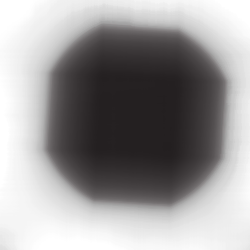

In [8]:
import cv2

blurred_etalon = cv2.medianBlur(image, FILTER_SIZE)

print("Эталонный результат:")
# Посмотрим на результат
Image.fromarray(blurred_etalon)

### Наивный алгоритм

Наивный алгоритм заключается в том, что мы для каждого окна фильтра ищем медиану путём сортировки яркостей пикселей.

_Примечание_: здесь и далее мы обрабатываем изображения размера $H \times W \times C$ фильтром радиуса $R$.

**Оценка времени работы:** размер окна фильтра - $(2R + 1)^2 = O(R^2)$. Для каждого положения окна фильтра мы производим сортировку серых пикселей за $O(R^2 log R^2) = O(R^2 log R)$, а затем берём центральный элемент за $O(1)$. Итого получаем асимптотику $O(HWC \times R^2 log R)$ для целого изображения.

**Оценка используемой памяти:** сортировку и получение итогового изображения мы делаем не in-place, поэтому нам потребуется $O(HWC + R^2)$ памяти.

In [21]:
from algorithms import NaiveMedianFilter

blurred_naive = NaiveMedianFilter().apply_fast(image, R)

Rows: 100%|██████████| 250/250 [00:36<00:00,  6.90it/s]


Результат работы совпадает с эталоном:


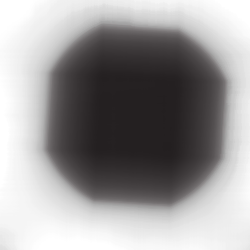

In [22]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_naive))
print("Результат работы совпадает с эталоном:")

# Посмотрим на результат
Image.fromarray(blurred_naive)

### Huang et al., "A Fast Two-Dimensional Median Filtering Algorithm"

Ссылка на оригинальную статью: https://www.uio.no/studier/emner/matnat/ifi/INF2310/v20/undervisningsmateriale/litteratur/huang-etal-median.pdf

Идея алгоритма состоит в использовании гистограммы значений в текущем окне фильтра для быстрого нахождения медианы.

**Оценка времени работы:** пусть $D$ - это число уровней квантования, тогда для каждого окна мы находим медиану с помощью гистограммы за $O(D)$, а переход к следующему окну совершаем за $O(R)$, получаем $O(D + R)$ на пиксель, а значит итоговое время работы - $O(HWC \times (D + R))$.

**Оценка используемой памяти:** обновление изображения мы всё ещё делаем не in-place. Хоть нам и не нужно хранить элементы текущего окна, теперь нам нужно хранить гистограмму за $O(D)$, а значит всего нам понадобится $O(HWC + D)$ памяти.

In [23]:
from algorithms import HuangMedianFilter

blurred_huang = HuangMedianFilter().apply(image, R)

Rows: 100%|██████████| 250/250 [00:37<00:00,  6.67it/s]


Результат работы совпадает с эталоном:


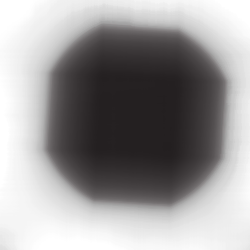

In [26]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_huang))
print("Результат работы совпадает с эталоном:")

# Посмотрим на результат
Image.fromarray(blurred_huang)

### Perreault and Hebert, "Median Filtering in Constant Time"

Ссылка на оригинальную статью: https://nomis80.org/ctmf.pdf

Как и предыдущий, этот подход основан на использовании гистограмм. Выигрыш происходит за счёт того, что мы храним гистограммы всех столбоцов на пути текущего окна, при этом на ходу подготавливая новые значения для перехода на следующую строку.

**Оценка времени работы:** обновления столбцов гистограмм происходят за $O(1)$, при этом инициализация окон, столбцов и переходы к следующему окну должны работать за $O(R)$. Однако для больших картинок мы получаем, что амортизированная стоимость обработки пикселя равна $O(1)$, а значит сложность алгоритма - $O(HWC)$.

**Оценка используемой памяти:** в этот раз расход памяти состоит из трёх пунктов:

1. Хранение результата - $O(HWC)$
2. Гистограммы каждого столбца - $O(DW)$
3. Гистограмма окна фильтра - $O(D)$

Итого требуется $O(HWC + DW + D) = O(HWC + DW)$ памяти.

In [4]:
from algorithms import ConstantTimeMedianFilter

blurred_constant_time = ConstantTimeMedianFilter().apply(image, R)

Channels: 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


Результат работы совпадает с эталоном:


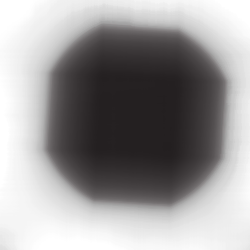

In [6]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_constant_time))
print("Результат работы совпадает с эталоном:")

# Посмотрим на результат
Image.fromarray(blurred_constant_time)

### Промежуточные выводы

1. Результат работы всех самописных алгоритмов совпадает с эталоном, а значит они реализованы корректно.

2. Среди всех алгоритмов по скорости, очевидно, выигрывает реализация из `OpenCV`. Это неудивительно, ведь она не только напиписана на С++, но и скорее всего оптимизирована как алгоритмически, так и программно (эффективное использование кэширования и векторизации). В связи с этим мы не будем включать её в дальнейшие сравнения, ведь это как минимум нечестно.

3. Среди самописных алгоритмов _в выбранных условиях_ быстрее всех оказался `ConstantTimeMedianFilter`, он быстрее остальных самописных реализаций _в 6 раз_.

Далее мы проведём более детальное сравнение.

## Сравнение самописных алгоритмов

Давайте сравним скорость работы самописных алгоритмов на каком-нибудь большом изображении (например, обоях для рабочего стола) при разных размерах фильтра.

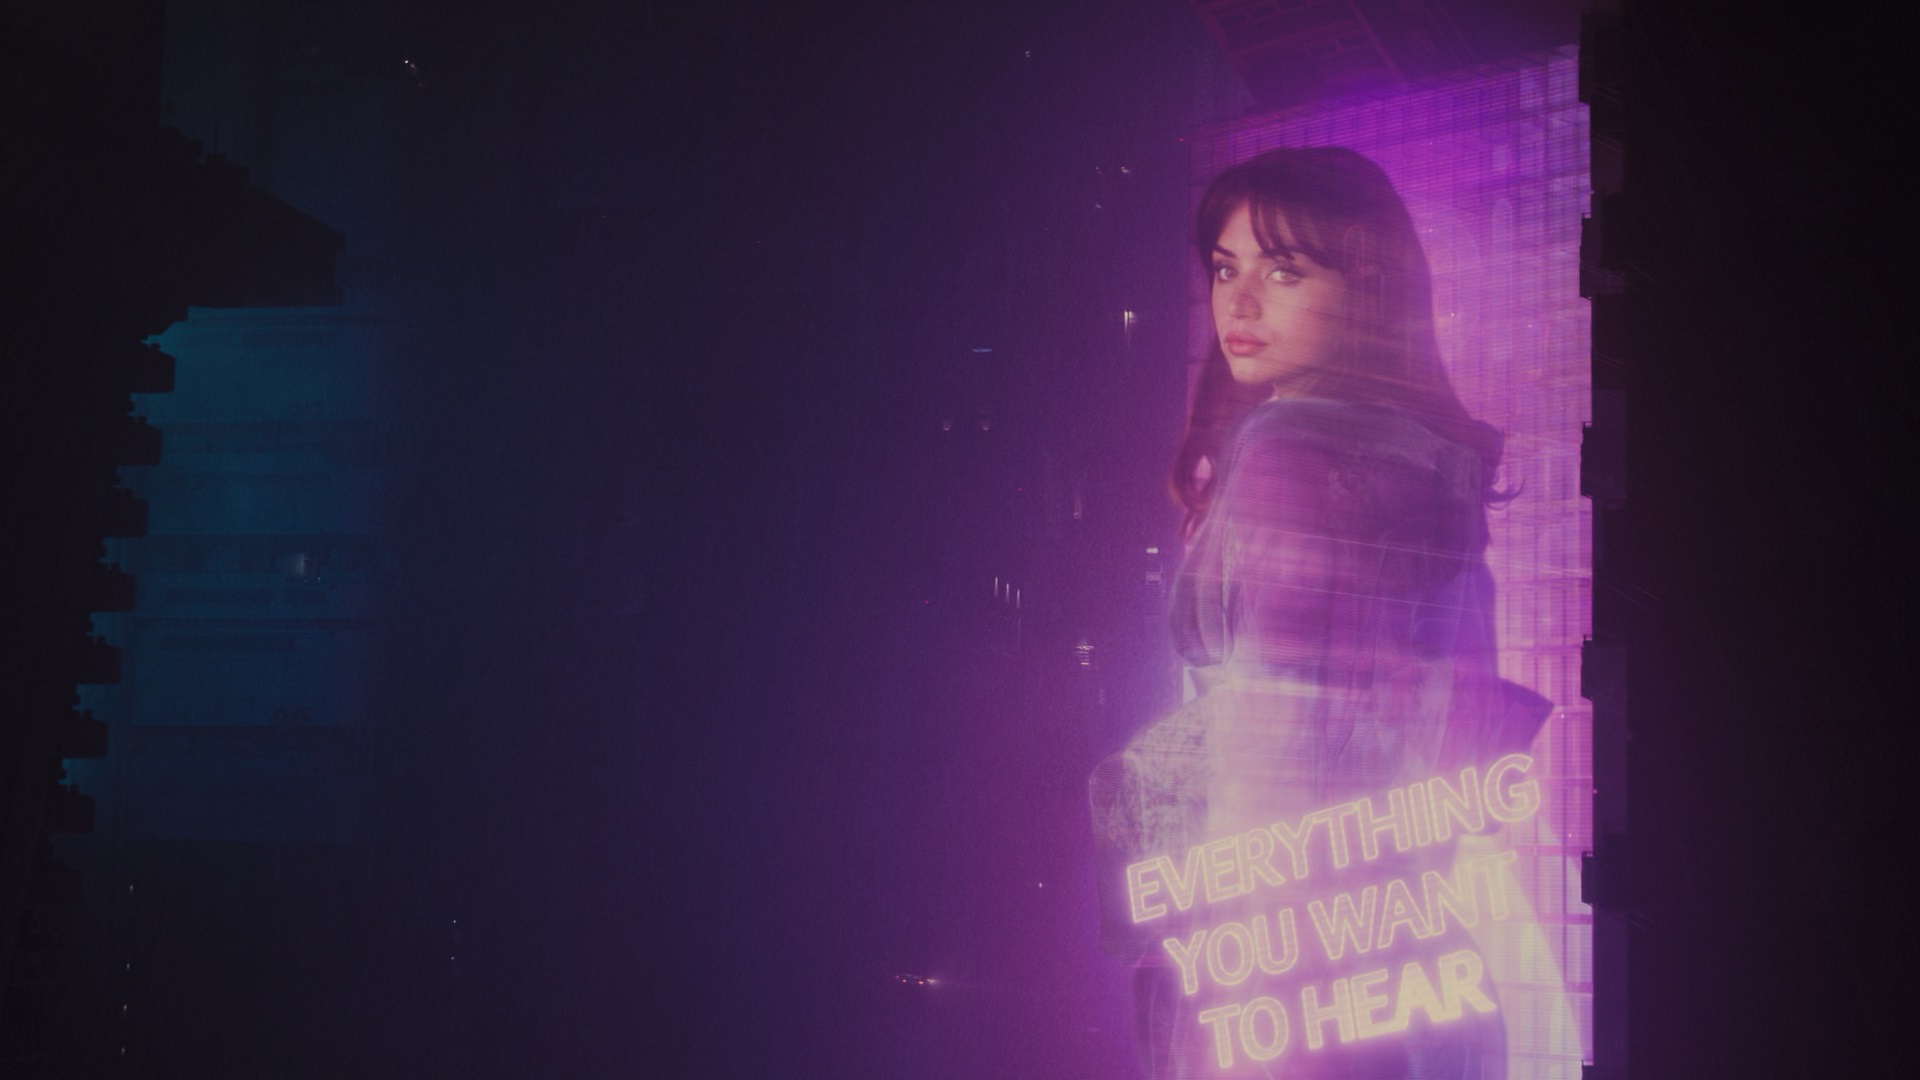

In [1]:
import numpy as np
from PIL import Image

# Загрузим изображение
wallpaper_image = Image.open("samples/Wallpaper.jpg")
wallpaper_image = np.array(wallpaper_image)

# А теперь посмотрим на него
Image.fromarray(wallpaper_image)

In [9]:
from utils.testing import test_algorithms
from algorithms import NaiveMedianFilter, HuangMedianFilter, ConstantTimeMedianFilter

# Сравним все три наших самописных алгоритма
algorithms = [NaiveMedianFilter, HuangMedianFilter, ConstantTimeMedianFilter]

# Сетку для радиусов возьмём следующей (перебирать много дискретных значений достаточно долго)
radii = [1, 2, 5, 10, 25, 50, 100]

# Запустим тестирование, результаты которого сохраним для построения графиков
measurements = test_algorithms(algorithms, wallpaper_image, radii)

=== Testing NaiveMedianFilter ===
Radius = 1


Rows: 100%|██████████| 1080/1080 [00:04<00:00, 252.89it/s]


Algorithm Speed = 2061.53 msecs/megapixels

Radius = 2


Rows: 100%|██████████| 1080/1080 [00:05<00:00, 211.44it/s]


Algorithm Speed = 2464.45 msecs/megapixels

Radius = 5


Rows: 100%|██████████| 1080/1080 [00:11<00:00, 91.32it/s]


Algorithm Speed = 5704.62 msecs/megapixels

Radius = 10


Rows: 100%|██████████| 1080/1080 [00:35<00:00, 30.11it/s]


Algorithm Speed = 17301.27 msecs/megapixels

Radius = 25


Rows: 100%|██████████| 1080/1080 [03:20<00:00,  5.38it/s]


Algorithm Speed = 96779.05 msecs/megapixels

Radius = 50


Rows: 100%|██████████| 1080/1080 [13:31<00:00,  1.33it/s]


Algorithm Speed = 391340.11 msecs/megapixels

Radius = 100


Rows: 100%|██████████| 1080/1080 [55:31<00:00,  3.09s/it]


Algorithm Speed = 1606789.41 msecs/megapixels

=== Testing HuangMedianFilter ===
Radius = 1


Rows: 100%|██████████| 1080/1080 [00:40<00:00, 26.55it/s]


Algorithm Speed = 19620.92 msecs/megapixels

Radius = 2


Rows: 100%|██████████| 1080/1080 [01:03<00:00, 17.00it/s]


Algorithm Speed = 30630.34 msecs/megapixels

Radius = 5


Rows: 100%|██████████| 1080/1080 [02:14<00:00,  8.01it/s]


Algorithm Speed = 65029.06 msecs/megapixels

Radius = 10


Rows: 100%|██████████| 1080/1080 [04:06<00:00,  4.38it/s]


Algorithm Speed = 118987.11 msecs/megapixels

Radius = 25


Rows: 100%|██████████| 1080/1080 [09:52<00:00,  1.82it/s]


Algorithm Speed = 285509.84 msecs/megapixels

Radius = 50


Rows: 100%|██████████| 1080/1080 [56:11<00:00,  3.12s/it]  


Algorithm Speed = 1625872.81 msecs/megapixels

Radius = 100


Rows: 100%|██████████| 1080/1080 [39:36<00:00,  2.20s/it]


Algorithm Speed = 1145989.09 msecs/megapixels

=== Testing ConstantTimeMedianFilter ===
Radius = 1


Channels: 100%|██████████| 3/3 [01:35<00:00, 31.71s/it]


Algorithm Speed = 45883.12 msecs/megapixels

Radius = 2


Channels: 100%|██████████| 3/3 [01:35<00:00, 31.73s/it]


Algorithm Speed = 45902.21 msecs/megapixels

Radius = 5


Channels: 100%|██████████| 3/3 [01:34<00:00, 31.44s/it]


Algorithm Speed = 45487.59 msecs/megapixels

Radius = 10


Channels: 100%|██████████| 3/3 [01:36<00:00, 32.01s/it]


Algorithm Speed = 46318.39 msecs/megapixels

Radius = 25


Channels: 100%|██████████| 3/3 [01:35<00:00, 31.88s/it]


Algorithm Speed = 46119.18 msecs/megapixels

Radius = 50


Channels: 100%|██████████| 3/3 [01:36<00:00, 32.21s/it]


Algorithm Speed = 46595.38 msecs/megapixels

Radius = 100


Channels: 100%|██████████| 3/3 [01:35<00:00, 31.92s/it]

Algorithm Speed = 46179.44 msecs/megapixels



_Примечание:_ во время работы `HuangMedianFilter` с радиусом 50 произошла некоторая проблема (если быть точнее - уснул ноутбук), поэтому время получилось сильно завышенным. Эта итерация была проведена заново, а в словаре `measurements` соответствующее значение было обновлено и теперь является корректным.

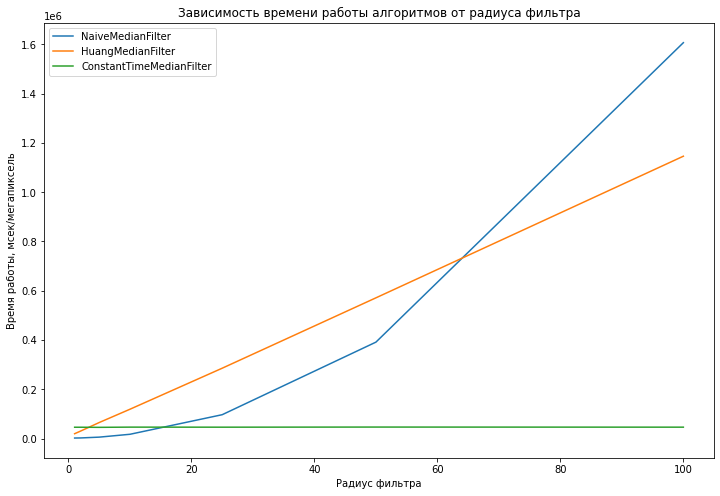

In [15]:
# Изобразим полученные данные на одном графике
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for algorithm_name in measurements:
    plt.plot(radii, measurements[algorithm_name])
    
plt.legend([algorithm_name for algorithm_name in measurements])

plt.title("Зависимость времени работы алгоритмов от радиуса фильтра")

plt.xlabel("Радиус фильтра")
plt.ylabel("Время работы, мсек/мегапиксель")

plt.show()

## Выводы

1. Вид графиков времени работы соответствует выведенным выше асимптотикам: у `NaiveMedianFilter` квадратичное время работы, у `HuangMedianFilter` - линейное, а у `ConstTimeMedianFilter` - константное.

2. Можно заметить, что не всегда выгоднее всего использовать последний алгоритм. Вместо этого можно использовать композицию следующего вида: если $R < 20$, то используем `NaiveMedianFilter`, иначе - `ConstTimeMedianFilter`.

3. На момент открытия `HuangMedianFilter` был хорошим алгоритмом, но, увы, его превзошёл `ConstTimeMedianFilter`, сильно улучшивший подход на основе гистограмм, поэтому в наших сравнениях он ничем не выделяется.

## Дополнительно

При анализе скорости алгоритмов мы не показывали результат фильтрации изображения, давайте посмотрим на него здесь и в лишний раз убедимся, что `ConstTimeMedianFilter` даёт тот же результат, что и эталонная реализация.

In [16]:
import numpy as np
from PIL import Image

# Загрузим изображение
wallpaper_image = Image.open("samples/Wallpaper.jpg")
wallpaper_image = np.array(wallpaper_image)

In [17]:
import cv2
from algorithms import ConstantTimeMedianFilter

# Радиус фильтра и соответствующий ему размер фильтра
R = 25
FILTER_SIZE = 2 * R + 1

# Обработаем изображение эталонным и нашим алгоритмом
blurred_etalon = cv2.medianBlur(wallpaper_image, FILTER_SIZE)
blurred_constant_time = ConstantTimeMedianFilter().apply(wallpaper_image, R)

Channels: 100%|██████████| 3/3 [01:39<00:00, 33.21s/it]


Результат работы совпадает с эталоном:


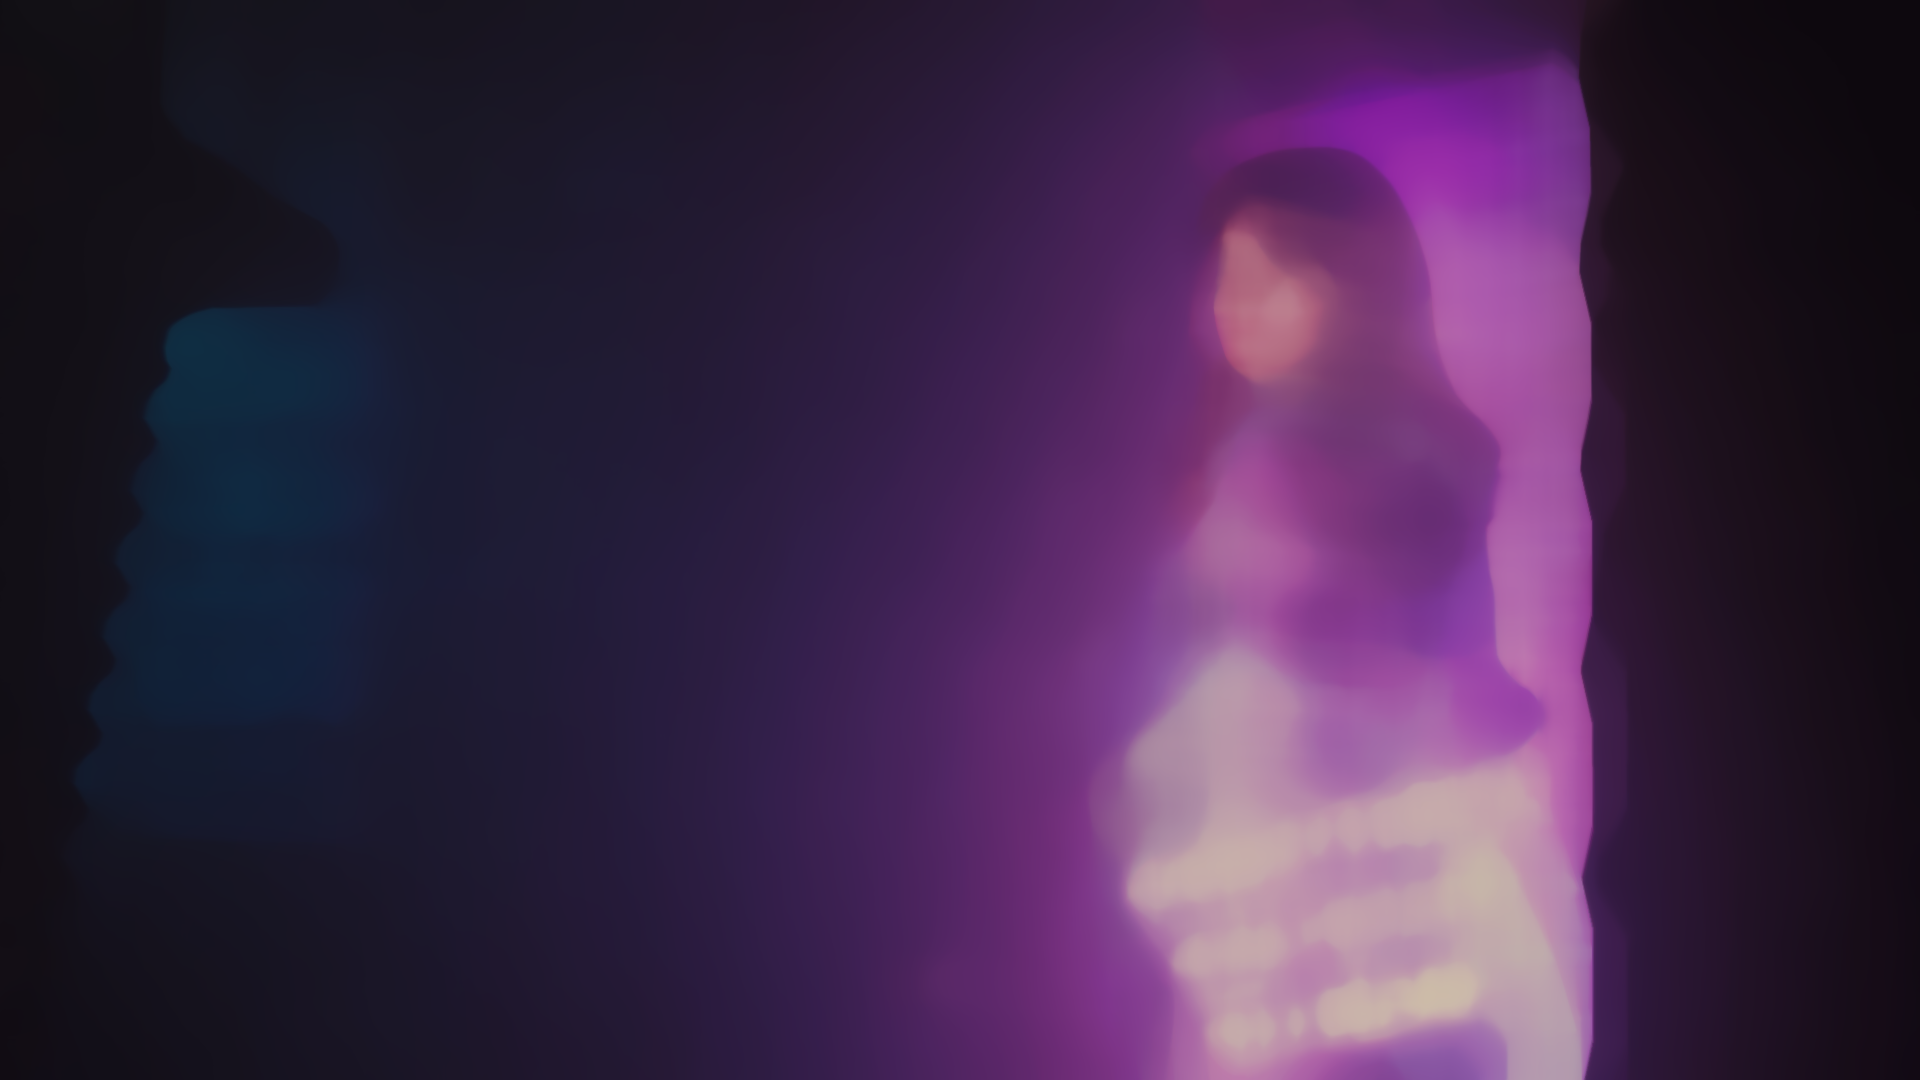

In [18]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_constant_time))
print("Результат работы совпадает с эталоном:")

# Посмотрим на результат
Image.fromarray(blurred_constant_time)